In [6]:
import numpy as np
import matplotlib.pyplot as plt
from iminuit import Minuit

In [7]:
# Gauss-Hermite quadrature points and weights
gausshermite_xi_deg25, gausshermite_wi_deg25 = np.polynomial.hermite.hermgauss(25)

In [8]:
# Target mean flux and P1D
def turner24_mf(z):
    return np.exp(-2.46e-3 * (1 + z)**3.62)


DESI_EDR_PARAMETERS = (
    7.63089e-02, -2.52054e+00, -1.27968e-01,
    3.67469e+00, 2.85951e-01, 7.33473e+02)


def evaluatePD13Lorentz(X, A, n, alpha, B, beta, lmd):
    k, z = X
    q0 = k / PD13_PIVOT_K + 1e-10

    result = (A * np.pi / PD13_PIVOT_K) * np.power(
        q0, 2. + n + alpha * np.log(q0)) / (1. + lmd * k**2)

    if z is not None:
        x0 = (1. + z) / (1. + PD13_PIVOT_Z)
        result *= np.power(q0, beta * np.log(x0)) * np.power(x0, B)

    return result

In [9]:
# Lognormal transformation functions
def D2_z(zp, nu=2.82):
    return np.power((1. + zp) / 4., -nu)

def t_of_z(zp, tau0=0.55, tau1=5.1):
    return tau0 * np.power((1. + zp) / 4., tau1)

def x_of_z(zp, tau0, tau1, nu, sigma2):
    return t_of_z(zp, tau0, tau1) * np.exp(-D2_z(zp, nu) * sigma2)

def Flux_d_z(delta_g, z, tau0, tau1, nu, sigma2):
    e1 = np.exp(2 * D2_z(z, nu / 2) * np.sqrt(2 * sigma2) * delta_g)
    e2 = x_of_z(z, tau0, tau1, nu, sigma2)
    return np.exp(-e2 * e1)

def lognMeanFluxGH(z, tau0, tau1, nu, sigma2):
    XIXI, ZZ = np.meshgrid(gausshermite_xi_deg25, z)

    Y = Flux_d_z(XIXI, ZZ, tau0, tau1, nu, sigma2)
    result = np.dot(Y, gausshermite_wi_deg25)

    return result / np.sqrt(np.pi)


# Input Gaussian power
def lognGeneratingPower(k, n=0.5, alpha=0.26, gamma=1.8, k1=0.04):
    q0 = np.log(k / 0.001 + 1e-15)
    return np.exp(n * q0 - alpha * q0**2) / (1. + (k / k1)**gamma) * np.exp(-(k / 0.2)**2 / 2)

In [5]:
# Fit for mean flux example
zarr = np.linspace(1.8, 5.0, 500)
precision = 1e-5
Fturner = turner24_mf(zarr)
Errturner = Fturner * precision + 1e-8

def cost(tau0, tau1, nu, sigma2):
    d = (Fturner - lognMeanFluxGH(zarr, tau0, tau1, nu, sigma2)) / Errturner
    return d.dot(d)

tau0, tau1, nu, sigma2 = 0.5, 5.1, 2.82, 1
mini = Minuit(cost, tau0, tau1, nu, sigma2)
mini.errordef = Minuit.LEAST_SQUARES
mini.migrad()

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 9.659e+05                  │              Nfcn = 548              │
│ EDM = 3.86e-05 (Goal: 0.0002)    │            time = 0.6 sec            │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name   │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼────────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ tau0   │ 673.77e-3 │  0.06e-3  │            │            │         │         │       │
│ 1 │ tau1   │  5.31008  │  0.00016  │            │            │         │         │       │
│ 2 │ nu     │  2.16175  │  0.00017  │            │            │         │         │       │
│ 3 │ sigma2 │  1.50381  │  0.00014  │            │            │         │         │       │
└───┴────────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌────────┬─────────────────────────────────────────┐
│        │      tau0      tau1        nu    sigma2 │
├────────┼─────────────────────────────────────────┤
│   tau0 │  3.73e-09 -6.34e-09  8.12e-09  8.77e-09 │
│   tau1 │ -6.34e-09  2.56e-08 -2.66e-08 -1.46e-08 │
│     nu │  8.12e-09 -2.66e-08  2.88e-08  1.89e-08 │
│ sigma2 │  8.77e-09 -1.46e-08  1.89e-08  2.07e-08 │
└────────┴─────────────────────────────────────────┘

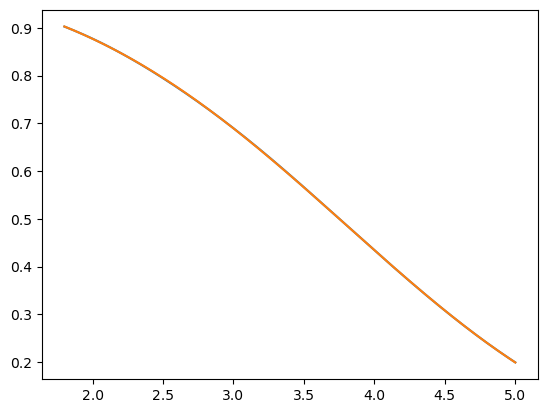

In [6]:
plt.plot(zarr, lognMeanFluxGH(zarr, *mini.values))
plt.plot(zarr, Fturner)

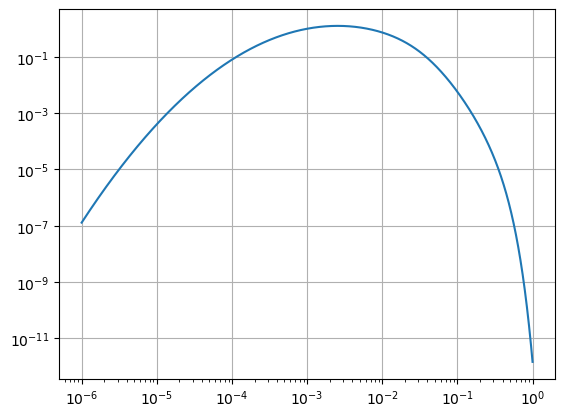

In [11]:
ka1 = np.logspace(-6, 0, 10000)
plt.loglog(ka1, lognGeneratingPower(ka1))
plt.grid()

In [12]:
2 * np.pi / (2**12*2*16)

4.7936899621426287e-05

In [13]:
# Calculate meshgrid for Gauss-Hermite once
YY1, YY2 = np.meshgrid(gausshermite_xi_deg25, gausshermite_xi_deg25, indexing='ij')
WW1, WW2 = np.meshgrid(gausshermite_wi_deg25, gausshermite_wi_deg25, indexing='ij')

numvpoints = 2**16
dv = 1.
k_arr  = 2. * np.pi * np.fft.rfftfreq(2 * numvpoints, d=dv)
z_p1d_arr = np.arange(13) * 0.2 + 2.0
p1d_edr_fit = np.empty((z_p1d_arr.size, k_arr.size))
for i, z in enumerate(z_p1d_arr):
    p1d_edr_fit[i] = evaluatePD13Lorentz((k_arr, z), *DESI_EDR_PARAMETERS)

In [14]:
xif_edr_fit = np.empty((z_p1d_arr.size, numvpoints))
for i, z in enumerate(z_p1d_arr):
    xif_edr_fit[i] = np.abs(np.fft.irfft(p1d_edr_fit[i]))[:numvpoints] / dv

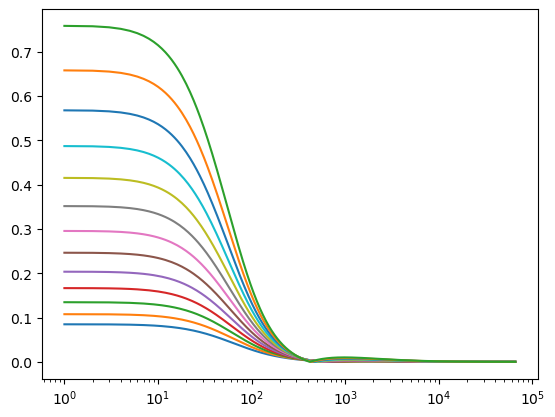

In [15]:
varr = np.arange(numvpoints) * dv
for z, xi in zip(z_p1d_arr, xif_edr_fit):
    plt.semilogx(1 + varr, xi, label=z)
# plt.yscale("symlog")

In [17]:
def lognXiFfromXiG(z, tau0, tau1, nu, xi_gauss):
    """
    Arguments
    ---------
    z: list(float)
        List of redshifts
    tau0, tau1: float
        Amplitude and power of optical depth
    nu: float
        Slope of growth (a(z))
    xi_gauss: np.array(float)
        numpy array of floats from v=0. size of numvpoints
        and dv as defined above cell
    """
    sigma2 = xi_gauss[0]
    xi_sine = np.clip(xi_gauss / sigma2, -1, 1)
    xi_cosine = np.sqrt(1 - xi_sine**2)
    XI_VEC = np.array([xi_sine, xi_cosine]).transpose()

    YY2_XI_VEC_WEIGHTED = np.dot(XI_VEC, np.array([YY1, YY2]).transpose(1, 0, 2))

    xi1d_arr = np.zeros((z.size, xi_gauss.size))

    # Redshift dependent 
    for zi, zr in enumerate(z):
        mean_flux_z = lognMeanFluxGH(zr, tau0, tau1, nu, sigma2)
        sigmaz = D2_z(zr, nu / 2) * np.sqrt(sigma2)
        tempxz = x_of_z(zr, tau0, tau1, nu, sigma2)
        delta1 = YY1 * sigmaz * 2 * np.sqrt(2)
        delta2 = YY2_XI_VEC_WEIGHTED * sigmaz * 2 * np.sqrt(2)

        F1 = np.exp(-tempxz * np.exp(delta1))
        F2 = np.exp(-tempxz * np.exp(delta2))
        D1 = F1 / mean_flux_z - 1
        D2 = F2 / mean_flux_z - 1
        tempfunc = WW1 * WW2 * D1 * D2

        xi1d_arr[zi] = np.sum(tempfunc, axis=(1, 2)) / np.pi

    return xi1d_arr

In [358]:
# You need to modify this to fit for correlation function.
# Reference codes are below
p1d_precision = 1e-1
w = (k_arr > 1e-3) & (k_arr < 0.05)
ptrue = p1d_edr_fit[:, w].ravel()
e_p1d = p1d_precision * ptrue + 1e-8

z_fbar_arr = np.linspace(2.0, 4.6, 50)
Fturner = turner24_mf(z_fbar_arr)
fbar_precision = 1e-3
e_fbar = Fturner * fbar_precision + 1e-8


tau0, tau1, nu = 673.77e-3, 5.31008, 2.16175 
n, alpha, gamma, k1 = 0.5, 0.26, 1.8, 0.04
log10p_init = np.array([-1, 0, -0.1, -2])  # np.array([np.log10(5e-4), -1, 0, -0.1, -2, -6])
log10p_prior = 0.1
amplitude = 60.


def cost_joint(tau0, tau1, nu, n, alpha, amplitude):
    cost = 0
    pgauss = amplitude * lognGeneratingPower2(k_arr, n, alpha)
    pgauss[0] = 0
    sigma2 = np.trapz(pgauss, dx=k_arr[1]) / np.pi

    p1d_f_calc = lognP1DFfromPG(
        z_p1d_arr, tau0, tau1, nu, pgauss, sigma2
    )[:, w].ravel()

    x = (p1d_f_calc - ptrue) / e_p1d
    cost += x.dot(x) / x.size

    x = (Fturner - lognMeanFluxGH(z_fbar_arr, tau0, tau1, nu, sigma2)) / e_fbar
    cost += x.dot(x) / x.size

    return cost

In [ ]:
# tau0, tau1, nu = 0.5, 5.1, 2.82
mini = Minuit(cost_joint, tau0, tau1, nu, n, alpha, amplitude)
mini.errordef = Minuit.LEAST_SQUARES

mini.limits['tau0'] = (0, 2)
mini.limits['n'] = (0, 25)
mini.limits['alpha'] = (0, 5)
# mini.limits['gamma'] = (0, 5)
# mini.limits['k1'] = (0, 0.2)
mini.limits['amplitude'] = (0, 200)
# for key in ['p0', 'p1', 'p2', 'p3']:
#     mini.limits[key] = (-12, 2)

for key in ['tau0', 'tau1', 'nu', 'gamma', 'k1', 'amplitude']:
    mini.fixed[key] = True

mini.migrad(ncall=10)

In [357]:
def lognP1DFfromPG(z, tau0, tau1, nu, pgauss, sigma2):
    """ For correlation function to correlation function see `lognXiFfromXiG`
    """
    xi_gaus_v = np.abs(np.fft.irfft(pgauss)) / dv

    xi_sine = np.clip(xi_gaus_v / sigma2, -1, 1)
    xi_cosine = np.sqrt(1 - xi_sine**2)
    XI_VEC = np.array([xi_sine, xi_cosine]).transpose()

    YY2_XI_VEC_WEIGHTED = np.dot(XI_VEC, np.array([YY1, YY2]).transpose(1, 0, 2))

    power_results_arr = np.zeros((z.size, k_arr.size))

    # Redshift dependent 
    for zi, zr in enumerate(z):
        mean_flux_z = lognMeanFluxGH(zr, tau0, tau1, nu, sigma2)
        sigmaz = D2_z(zr, nu / 2) * np.sqrt(sigma2)
        tempxz = x_of_z(zr, tau0, tau1, nu, sigma2)
        delta1 = YY1 * sigmaz * 2 * np.sqrt(2)
        delta2 = YY2_XI_VEC_WEIGHTED * sigmaz * 2 * np.sqrt(2)

        F1 = np.exp(-tempxz * np.exp(delta1))
        F2 = np.exp(-tempxz * np.exp(delta2))
        D1 = F1 / mean_flux_z - 1
        D2 = F2 / mean_flux_z - 1
        tempfunc = WW1 * WW2 * D1 * D2

        xi_ln_f = np.transpose(np.sum(tempfunc, axis=(1, 2)) / np.pi)
        power_results_arr[zi] = np.abs(np.fft.rfft(xi_ln_f)) * dv

    return power_results_arr

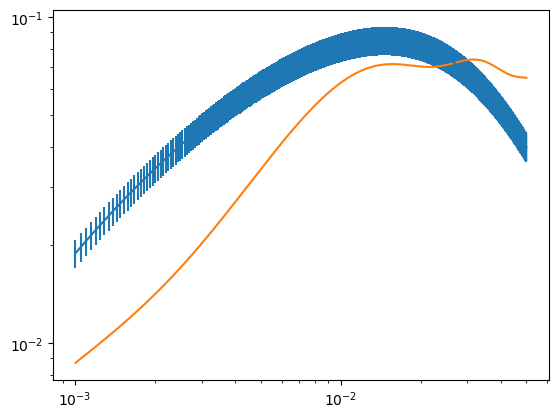

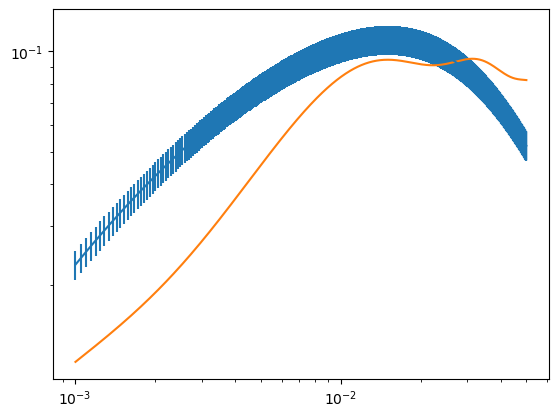

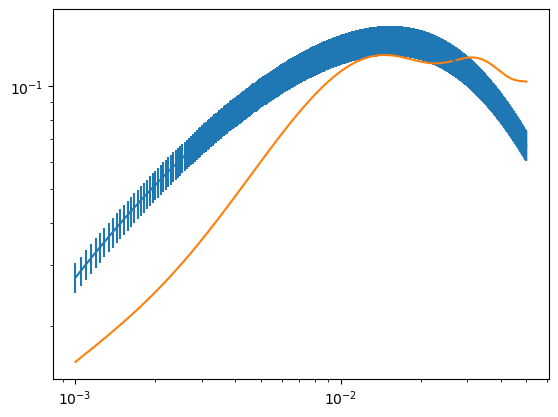

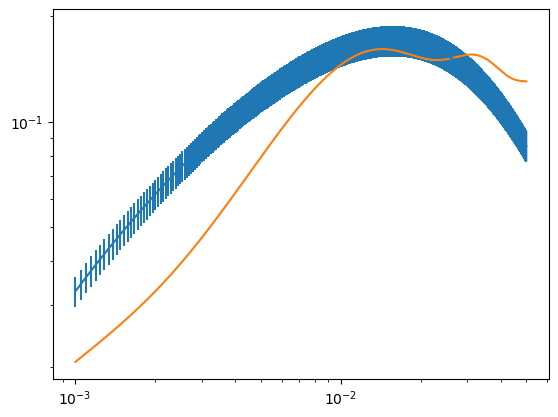

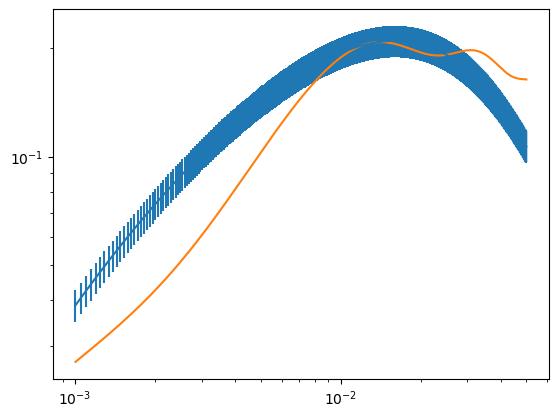

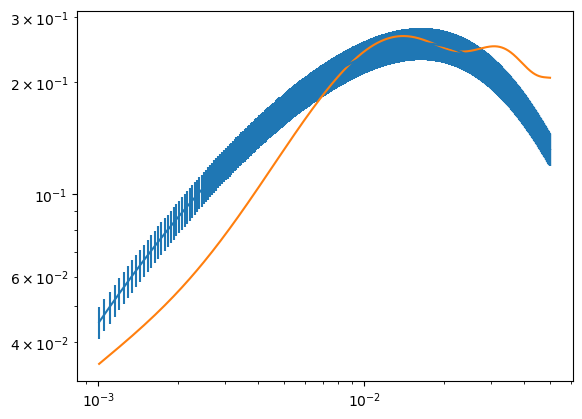

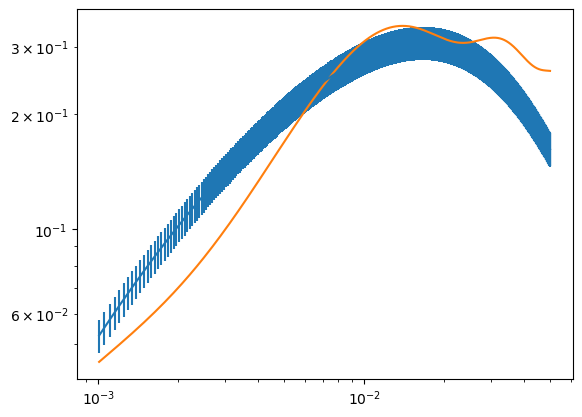

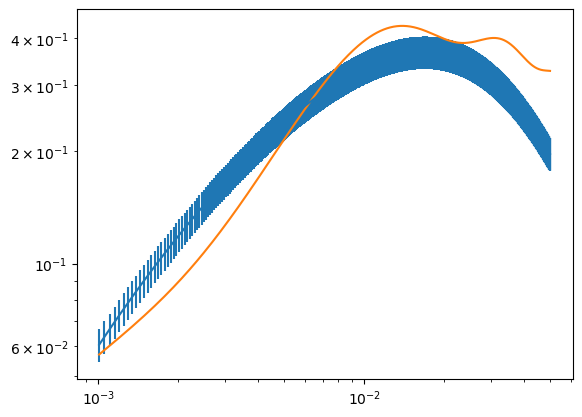

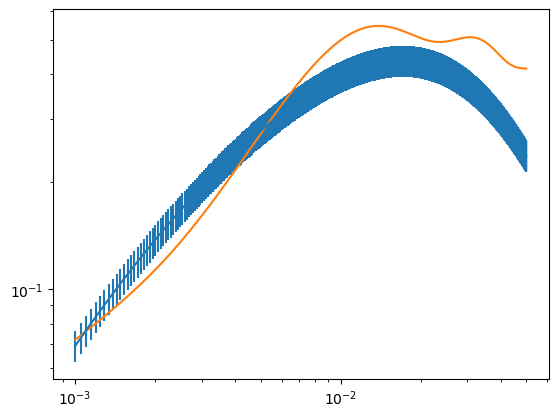

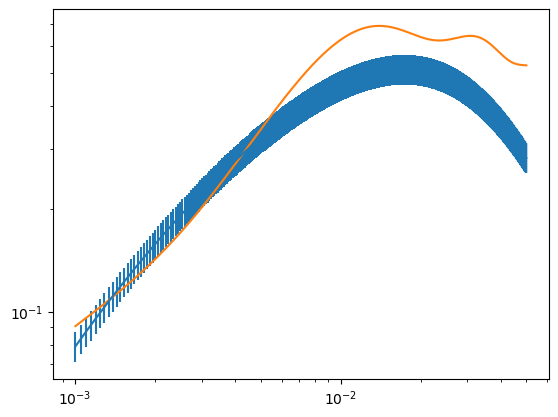

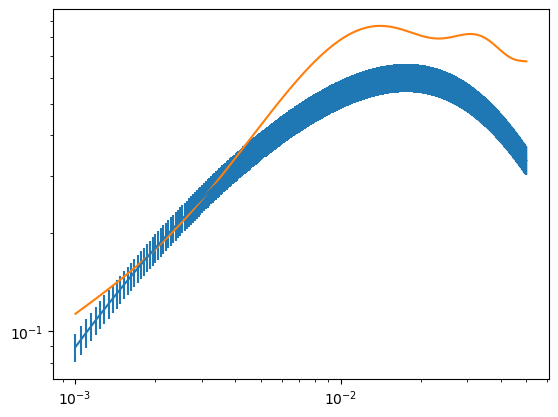

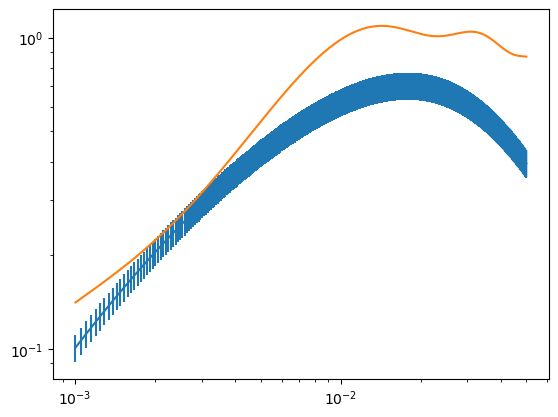

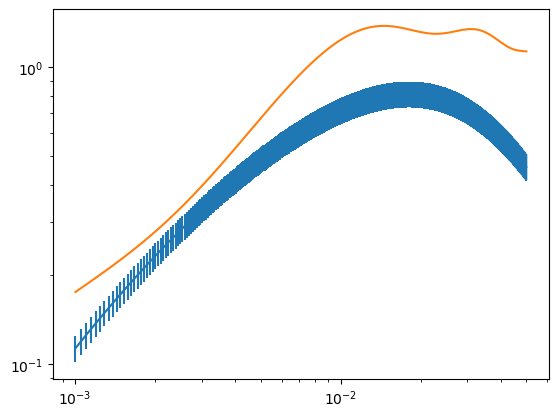

In [359]:
pgauss = amplitude * lognGeneratingPower(k_arr, n, alpha)
pgauss[0] = 0
sigma2 = np.trapz(pgauss, dx=k_arr[1]) / np.pi

p1d_f_calc = lognP1DFfromPG(
    z_p1d_arr, tau0, tau1, nu, pgauss, sigma2
)[:, w]

for i, z in enumerate(z_p1d_arr):
    e = e_p1d.reshape(z_p1d_arr.size, w.sum())[i] * k_arr[w]
    plt.errorbar(k_arr[w], p1d_edr_fit[i, w] * k_arr[w], e)
    plt.loglog(k_arr[w], p1d_f_calc[i] * k_arr[w], label=z)
    plt.show()

In [332]:
# tau0, tau1, nu = 0.5, 5.1, 2.82
mini = Minuit(cost_joint, tau0, tau1, nu, n, alpha, amplitude)
mini.errordef = Minuit.LEAST_SQUARES

mini.limits['tau0'] = (0, 2)
mini.limits['n'] = (0, 25)
mini.limits['alpha'] = (0, 5)
# mini.limits['gamma'] = (0, 5)
# mini.limits['k1'] = (0, 0.2)
mini.limits['amplitude'] = (0, 200)
# for key in ['p0', 'p1', 'p2', 'p3']:
#     mini.limits[key] = (-12, 2)

for key in ['tau0', 'tau1', 'nu', 'gamma', 'k1', 'amplitude']:
    mini.fixed[key] = True

mini.migrad(ncall=10)

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 1.189e+04                  │              Nfcn = 24               │
│ EDM = 3.24e+04 (Goal: 0.0002)    │           time = 31.4 sec            │
├──────────────────────────────────┼──────────────────────────────────────┤
│         INVALID Minimum          │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           ABOVE call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │APPROXIMATE│  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬───────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name      │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼───────────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ tau0      │   0.674   │   0.007   │            │            │    0    │    2    │  yes  │
│ 1 │ tau1      │   5.31    │   0.05    │            │            │         │         │  yes  │
│ 2 │ nu        │   2.162   │   0.022   │            │            │         │         │  yes  │
│ 3 │ n         │  0.8946   │  0.0016   │            │            │    0    │   25    │       │
│ 4 │ alpha     │ 260.0e-3  │  0.5e-3   │            │            │    0    │    5    │       │
│ 5 │ gamma     │   1.800   │   0.018   │            │            │    0    │    5    │  yes  │
│ 6 │ k1        │  40.0e-3  │  0.4e-3   │            │            │    0    │   0.2   │  yes  │
│ 7 │ amplitude │   60.0    │    0.6    │            │            │    0    │   200   │  yes  │
└───┴───────────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌───────────┬─────────────────────────────────────────────────────────────────────────────────┐
│           │      tau0      tau1        nu         n     alpha     gamma        k1 amplitude │
├───────────┼─────────────────────────────────────────────────────────────────────────────────┤
│      tau0 │         0         0         0         0         0         0         0         0 │
│      tau1 │         0         0         0         0         0         0         0         0 │
│        nu │         0         0         0         0         0         0         0         0 │
│         n │         0         0         0   2.5e-06         0         0         0         0 │
│     alpha │         0         0         0         0  2.39e-07         0         0         0 │
│     gamma │         0         0         0         0         0         0         0         0 │
│        k1 │         0         0         0         0         0         0         0         0 │
│ amplitude │         0         0         0         0         0         0         0         0 │
└───────────┴─────────────────────────────────────────────────────────────────────────────────┘

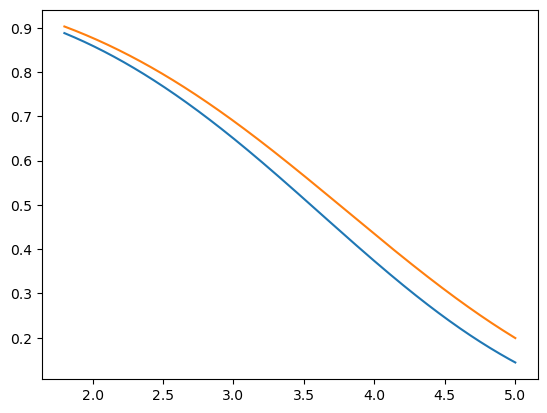

In [333]:
pgauss = mini.values['amplitude'] * lognGeneratingPower(k_arr, *mini.values['n', 'alpha', 'gamma', 'k1'])
sigma2 = np.trapz(pgauss, dx=k_arr[1]) / np.pi
plt.plot(zarr, lognMeanFluxGH(zarr, *mini.values['tau0', 'tau1', 'nu'], sigma2))
plt.plot(zarr, turner24_mf(zarr))

In [334]:
print(sigma2)

1.0473282609563046


In [335]:
p1dfit = lognP1DFfromPG(z_p1d_arr, *mini.values['tau0', 'tau1', 'nu'], pgauss, sigma2)

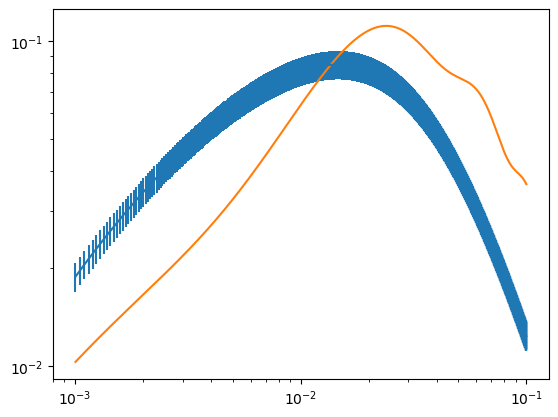

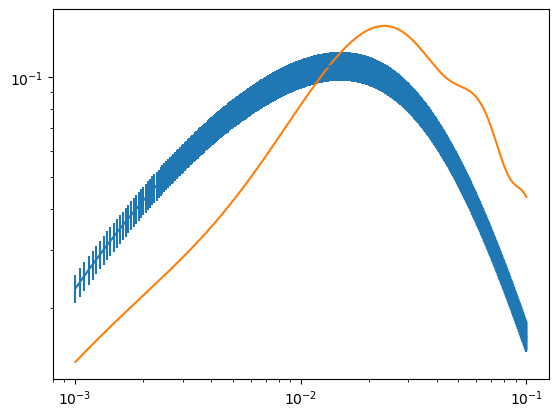

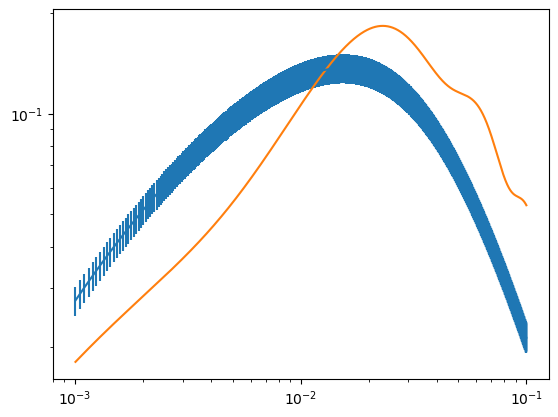

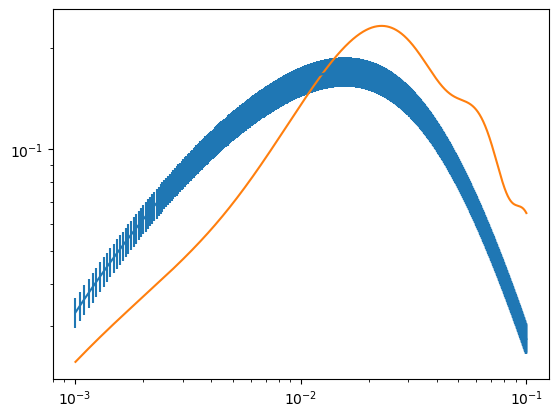

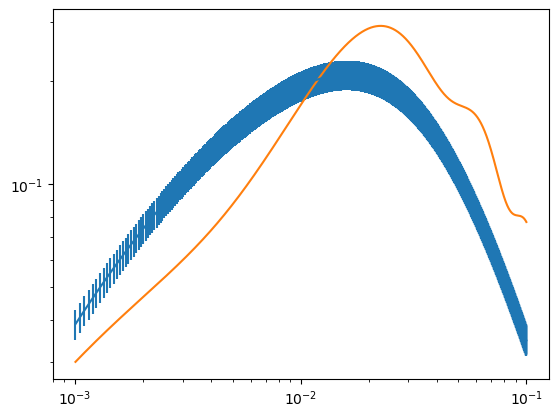

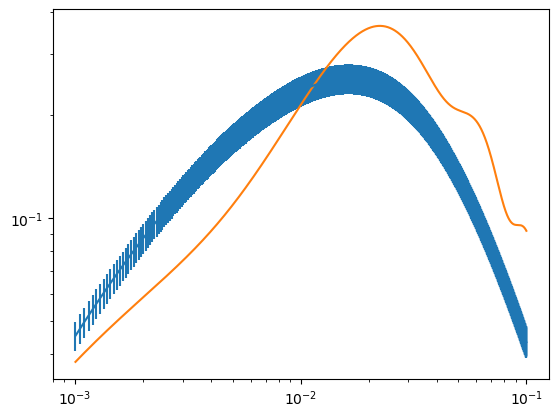

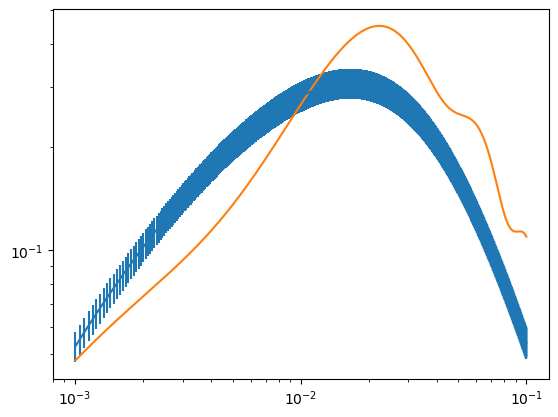

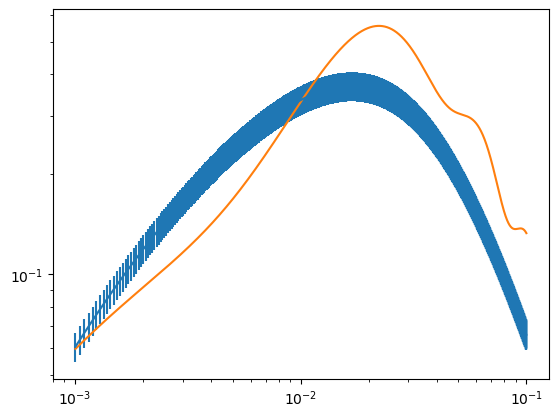

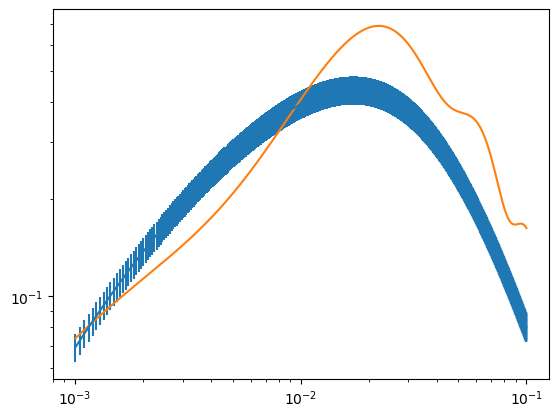

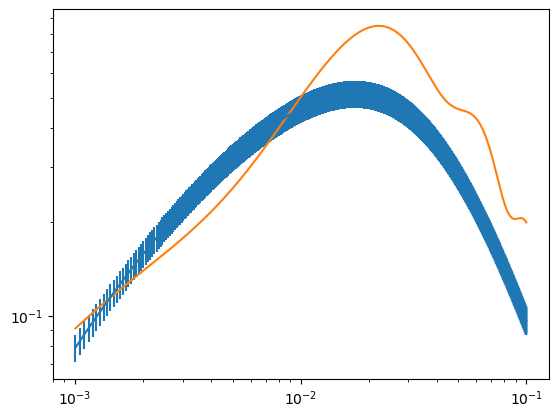

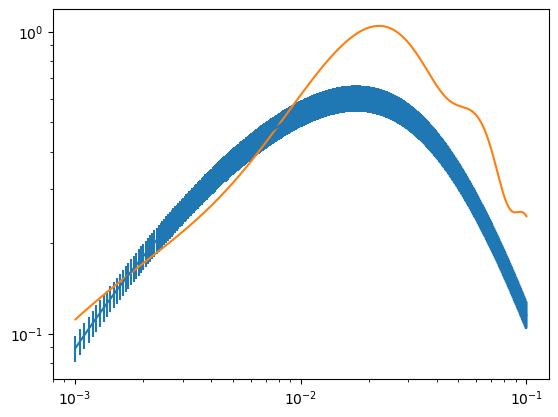

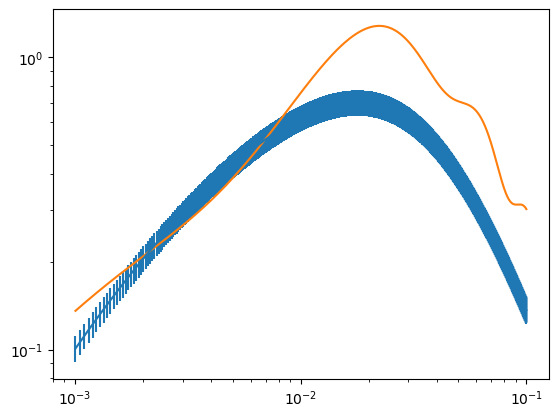

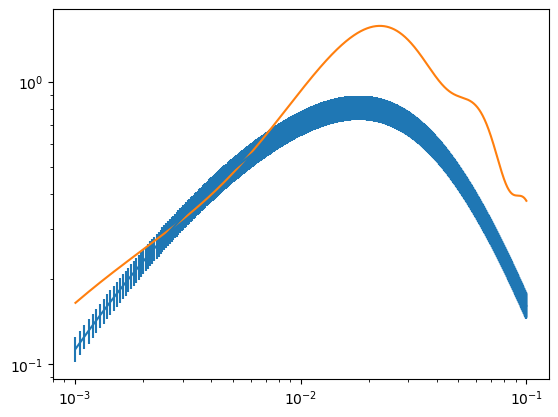

In [336]:
for i, z in enumerate(z_p1d_arr):
    e = e_p1d.reshape(z_p1d_arr.size, w.sum())[i] * k_arr[w]
    plt.errorbar(k_arr[w], p1d_edr_fit[i, w] * k_arr[w], e)
    plt.loglog(k_arr[w], p1dfit[i, w] * k_arr[w], label=z)
    plt.show()

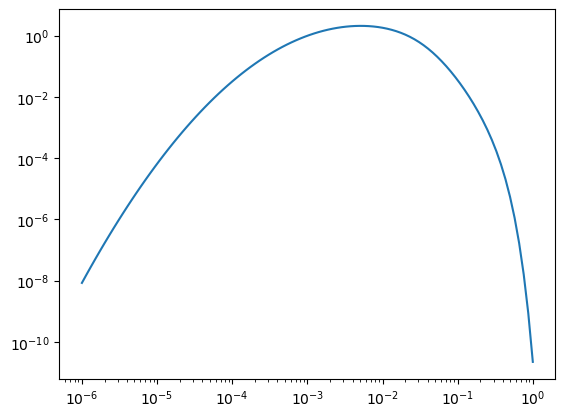

In [337]:
ka1 = np.logspace(-6, 0, 100)
plt.loglog(ka1, lognGeneratingPower(ka1, *mini.values['n', 'alpha', 'gamma', 'k1']))
del ka1

In [68]:
lognP1DFfromPG(z_p1d_arr, *mini.values['tau0', 'tau1', 'nu'], n=0.5, alpha=0.26, gamma=1.8, k1=0.05)

array([[2.13964541e-01, 2.13896842e-01, 2.13733248e-01, ...,
        7.39639054e-04, 7.39616333e-04, 7.39574310e-04],
       [3.66515207e-01, 3.66399142e-01, 3.66118670e-01, ...,
        1.25687820e-03, 1.25683925e-03, 1.25676720e-03],
       [6.07540431e-01, 6.07347898e-01, 6.06882639e-01, ...,
        2.06900410e-03, 2.06893948e-03, 2.06881997e-03],
       ...,
       [1.49036301e+01, 1.48989087e+01, 1.48874994e+01, ...,
        5.09209507e-02, 5.09193661e-02, 5.09164353e-02],
       [2.05974004e+01, 2.05908869e+01, 2.05751469e+01, ...,
        7.15448692e-02, 7.15426831e-02, 7.15386400e-02],
       [2.81178435e+01, 2.81089750e+01, 2.80875441e+01, ...,
        1.00008354e-01, 1.00005378e-01, 9.99998730e-02]])

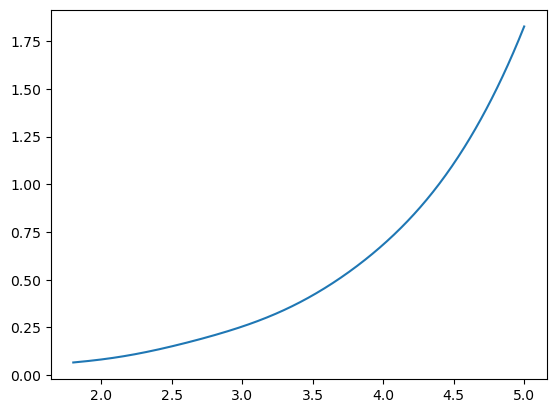

In [29]:
plt.plot(zarr, lognXiFfromXiG(zarr, *mini.values, xi0_G=1))

In [ ]:
def lognPowerSpGH(z, tau0, tau1, nu, sigma2, numvpoints=2**18, dv=1.):
    if isinstance(z, float):
        z = np.array([z]) 
    # Set up k array
    k_arr  = 2. * np.pi * np.fft.rfftfreq(numvpoints, d=dv)

    # Compute correlation function for the underlying Gaussian fiels
    xi_gaus_v = np.abs(np.fft.irfft(lognGeneratingPower(k_arr))) / dv #[:int(numvpoints/2)]
    sigma2 = xi_gaus_v[0]
    xi_sine = xi_gaus_v / sigma2
    xi_sine[xi_sine>1] = 1.
    xi_cosine = np.sqrt(1 - xi_sine**2)
    XI_VEC = np.array([xi_sine, xi_cosine]).transpose()

    # Set up Gauss-Hermite quadrature
    YY1, YY2 = np.meshgrid(gausshermite_xi_deg25, gausshermite_xi_deg25, indexing='ij')
    WW1, WW2 = np.meshgrid(gausshermite_wi_deg25, gausshermite_wi_deg25, indexing='ij')
    YY2_XI_VEC_WEIGHTED = np.dot(XI_VEC, np.array([YY1, YY2]).transpose(1,0,2))
    
    if corr:
        corr_results_arr = np.zeros((z.size, numvpoints))
    else:
        power_results_arr = np.zeros((z.size, k_arr.size))
    # Redshift dependent 
    for zi, zr in enumerate(z):
        mean_flux_z = lognMeanFluxGH(zr)
        sigmaz = np.sqrt(a2_z(zr) * sigma2)
        tempxz = x_of_z(zr)
        delta1 = YY1 * sigmaz * 2 * np.sqrt(2)
        delta2 = YY2_XI_VEC_WEIGHTED * sigmaz * 2 * np.sqrt(2)

        fofdeltag = lambda delta_g: np.exp(-tempxz * np.exp(delta_g))
        F1 = fofdeltag(delta1)
        F2 = fofdeltag(delta2)
        D1 = F1/mean_flux_z-1
        D2 = F2/mean_flux_z-1
        tempfunc = WW1*WW2*D1*D2

        xi_ln_f = np.transpose(np.sum(tempfunc, axis=(1,2)) / np.pi)
        if corr:
            corr_results_arr[zi] = xi_ln_f
        else:
            power_results_arr[zi] = np.fft.rfft(xi_ln_f).real * dv
    
    if corr:
        return np.arange(numvpoints) * dv, corr_results_arr
    else:
        return k_arr, power_results_arr

In [ ]:
from scipy.interpolate import CubicSpline
class SplinePower:
    pivots = np.arange(-4, 0)
    dlog10k = 0.05

    def __init__(self, log10ps):
        self._spl = None
        self.a1 = 0
        self.n1 = 0
        self.n2 = 0
        self.b2 = 0
        self.create(*log10ps)

    def create(self, *log10ps):
        self._spl = CubicSpline(SplinePower.pivots, log10ps, bc_type='natural')
        
        y0 = self._spl(SplinePower.pivots[0])
        yp0 = self._spl(SplinePower.pivots[0], nu=1)
        self.a1 = (y0 - yp0 * SplinePower.pivots[0]) / SplinePower.pivots[0]**2
        self.n1 = 2 * y0 / SplinePower.pivots[0] - yp0

        self.n2 = (
            self._spl(SplinePower.pivots[-1])
            - self._spl(SplinePower.pivots[-1] - SplinePower.dlog10k)
            ) / SplinePower.dlog10k

        self.b2 = self._spl(SplinePower.pivots[-1]) - self.n2 * SplinePower.pivots[-1]

    def __call__(self, k):
        log10k = np.log10(k + 1e-15)
        i1, i2 = np.searchsorted(log10k, SplinePower.pivots[[0, -1]])
        result = np.empty(log10k.size)
        result[:i1] = self.n1 * log10k[:i1] - self.a1 * log10k[:i1]**2
        result[i1:i2] = self._spl(log10k[i1:i2])
        result[i2:] = self.n2 * log10k[i2:] + self.b2

        return 10**(result) * np.exp(-(k / 0.2)**2)